# BASIC STEPS IN EXPLORATORY DATA ANALYSIS

This notebook contain the main basic steps that should be performed during exploratory data analysis of experimental data for protein engineering. It is important to note that this is not an exhaustive procedure. It only include the minimal number of steps that should be performed and further steps might be required depending on the specific characteristics of the raw data and objective.

# 1. exploring the label of the data

The firsts part of this tutorial includes the exploration and understanding of the experimental label of the data

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.insert(1, '/raid/data/fherrera/Protein_Engineering_Code_Center/src/')
from data_processing import DataProcessing

The datset used in this tutorial correspond to alpha amylase obtained from: 

https://github.com/the-protein-engineering-tournament/pet-pilot-2023

In [2]:
data = pd.read_csv('../Data/raw_data/Alpha_Amylase.csv')
data.head()

,mutant,dataset,mutated_sequence,expression
0,S142L-T152P-L158V-G298M-E351Q,2,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.815
1,K007D,1,LTAPSIDSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.830
2,A086E,1,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,1.560
3,S005E-S131H,2,LTAPEIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.452
4,T413H,1,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,1.010


The first step is to check for invalid or NaN entries. These entries must be removed as they are not useful for any prediction purpose

In [18]:
number_of_entries = data['expression'].shape[0]
print (f'Number of entries in the raw dataset: {number_of_entries}')

Number of entries in the raw dataset: 12294


In [19]:
expression_nan_count = data['expression'].isna().sum()
print(f'Number of NaN values in expression column: {expression_nan_count}')

Number of NaN values in expression column: 924


In [20]:
data_no_nan = data.dropna(subset=['expression'])
number_of_entries_no_nan = data_no_nan['expression'].shape[0]
print(f'Number of entries in the dataset after removing NaN values: {number_of_entries_no_nan}')

Number of entries in the dataset after removing NaN values: 11370


In the original dataset, the label (expression) is provided as the ratio of the expression of the variant with respect to the wild type. Transforming this label to a logarithmic scale can facilitate the interpretation of the label, eventually easing the exploratory data analysis and supporting the decision making process.

In [32]:
log_expression =  DataProcessing.transform_to_logarithmic(data_no_nan ['expression'])
data_no_nan.loc[:, 'Log_expression'] = log_expression
data_no_nan .head()

,mutant,dataset,mutated_sequence,expression,Log_expression
0,S142L-T152P-L158V-G298M-E351Q,2,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.815,-0.204567
1,K007D,1,LTAPSIDSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.830,-0.186330
2,A086E,1,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,1.560,0.444686
3,S005E-S131H,2,LTAPEIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.452,-0.794073
4,T413H,1,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,1.010,0.009950


It is a good practice to save the cleaned dataset in a different file instead of overwriting the original file. This allows keeping track of the changes in the data.

In [22]:
data_no_nan.to_csv('../Data/Cleaned_data/Alpha_Amylase_cleaned.csv', index=False)

In [22]:
data_no_nan['Log_expression'].describe()

count    11370.000000
mean        -1.111259
std          1.212110
min         -2.995732
25%         -2.302585
50%         -0.621757
75%         -0.072571
max          1.161274
Name: Log_expression, dtype: float64

Text(0, 0.5, 'Log_expression Value')

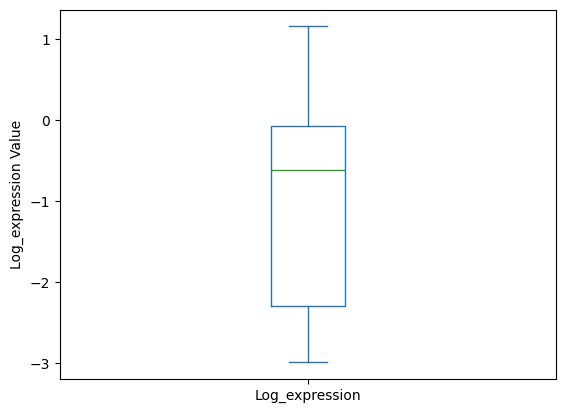

In [23]:
data_no_nan['Log_expression'].plot(kind='box')
plt.ylabel('Log_expression Value')

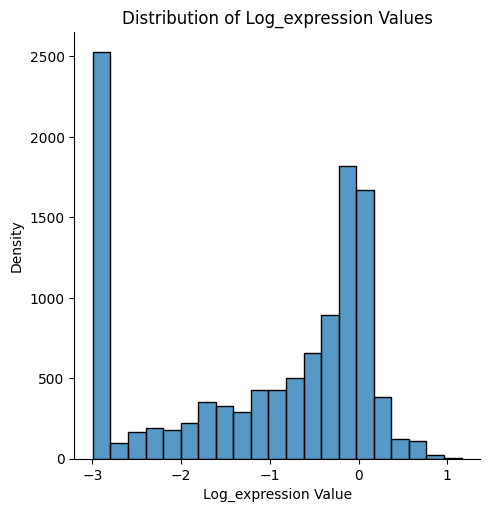

In [24]:

sns.displot(data_no_nan['Log_expression'])
plt.xlabel('Log_expression Value')
plt.ylabel('Density')
plt.title('Distribution of Log_expression Values')
plt.show()

The general descriptive statistics shows that most of the variants in the dataset are detrimental mutations as the logarithmic expression values are mostly negative. Less than 25% of the data consists of neutral or beneficial mutants. 

# 2. exploring the feature space and the its relationship with the label

This step consists of performing different dimensionality reduction techniques of the numerical representations of the sequences and calculating correlations with the label. All these numerical representation were previously calculated (see script ´../sequence_representation.py´)

In [6]:
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [34]:
one_hot_data = pd.read_csv('../Data/numeric_representations/one_hot.csv')

with h5py.File('../Data/numeric_representations/esm1v.h5', 'r') as f:
    esm1v = np.array(f['esm1v'])
    esm1v = esm1v.squeeze(1)

with h5py.File('../Data/numeric_representations/prott5.h5', 'r') as f:
    prott5 = np.array(f['prott5'])
    prott5 = prott5.squeeze(1)

esm1v_df = pd.DataFrame(esm1v)
prott5_df = pd.DataFrame(prott5) 

In [36]:
pca =PCA(n_components=2)

In [39]:
pca_one_hot = pca.fit_transform(one_hot_data)

esm1v_df.columns = esm1v_df.columns.astype(str)
pca_esm1v = pca.fit_transform(esm1v_df)

prott5_df.columns = prott5_df.columns.astype(str)
pca_prott5 = pca.fit_transform(prott5_df)

In [44]:
pca_prott5.shape

(11370, 2)

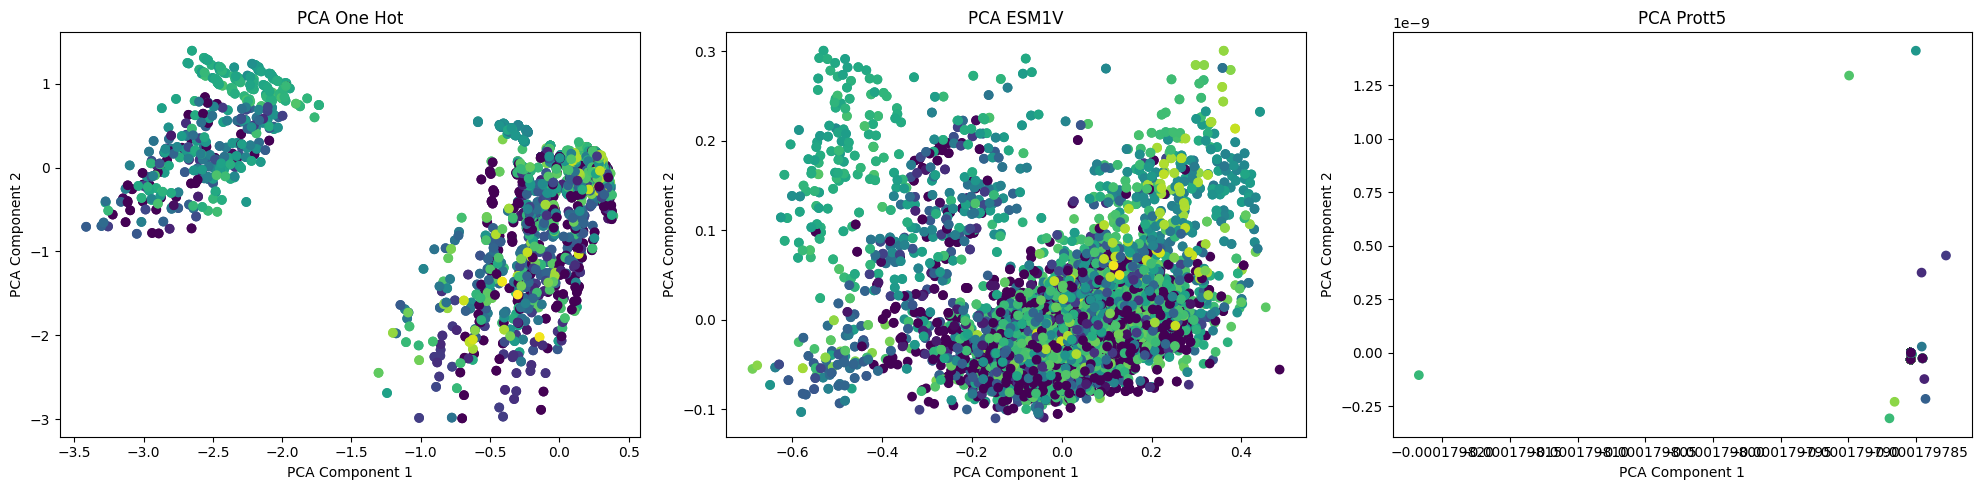

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].scatter(pca_one_hot[:, 0], pca_one_hot[:, 1], c=data_no_nan['Log_expression'])
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].set_title('PCA One Hot')

axes[1].scatter(pca_esm1v[:, 0], pca_esm1v[:, 1], c=data_no_nan['Log_expression'])
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')
axes[1].set_title('PCA ESM1V')

axes[2].scatter(pca_prott5[:, 0], pca_prott5[:, 1], c=data_no_nan['Log_expression'])
axes[2].set_xlabel('PCA Component 1')
axes[2].set_ylabel('PCA Component 2')
axes[2].set_title('PCA Prott5')

plt.tight_layout()
plt.show()
